### Trying to solve Task 4 now!

In [1]:
random_state = 42
EPOCHS = 200
BATCH_SIZE = 128
BATCH_SIZE_IM = 16
EMB_SIZE = 256

In [2]:
!pip install sklearn numpy matplotlib psutil pandas

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
!pip install -U tensorboard_plugin_profile

Requirement already up-to-date: tensorboard_plugin_profile in /usr/local/lib/python3.6/dist-packages (2.4.0)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
%load_ext tensorboard

In [5]:
%tensorboard --logdir logs/ --bind_all

In [6]:
# run for a remote notebook: docker run -it --gpus all -v /root/iml2021/task4:/tf/task4 -p 8888:8888 tensorflow/tensorflow:latest-gpu-jupyter
# need stuff cd /task4 && python -m pip install sklearn numpy matplotlib psutil pandas && python3 task4.py
from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
#from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate, Lambda, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import Dataset
from tensorflow import keras
from keras import backend as K
import tensorflow as tf

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
from lru_cache_memory_aware import lru_cache
from datetime import datetime
from packaging import version
import multiprocessing

Following is the example by keras.

In [7]:
# TODO https://keras.io/api/applications/resnet/ use ResNet50v2 and then one last time ResNet152v2
def example():
  model = ResNet50(
      include_top=True,
      weights="imagenet",
      input_tensor=None,
      input_shape=None,
      pooling=None,
      classes=1000,
      classifier_activation="softmax",
  )
  img_path = 'food/00000.jpg'
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  # decode the results into a list of tuples (class, description, probability)
  # (one such list for each sample in the batch)
  print('Predicted:', decode_predictions(preds, top=3)[0])

In [8]:
%%capture
!unzip -o food.zip

In [9]:
trainPD = pd.read_csv("train_triplets.txt", header=None, delimiter=' ')
testPD = pd.read_csv("test_triplets.txt", header=None, delimiter=' ')

In [10]:
# Add the y lable, where 1 means exactly what the exercise defines,
# i.e. 0 is closer in taste to 1 than 2
trainPD['y'] = pd.DataFrame(np.ones((trainPD.shape[0],1)), columns=["y"])
trainPD.columns = ['A', 'B', 'C', 'y']
trainPD = trainPD.sample(frac=1, random_state=random_state).reset_index(drop=True)
trainPDreverseF = trainPD.copy()
trainPDreverseF["A"] = trainPD["B"].copy()
trainPDreverseF["B"] = trainPD["A"].copy()
trainPD = trainPD.append(trainPDreverseF).reset_index(drop=True)
trainPD

,A,B,C,y
0,1623,1263,4221,1.0
1,2841,4262,3258,1.0
2,2,3453,1963,1.0
3,1205,3519,4785,1.0
4,3427,2101,2799,1.0
...,...,...,...,...
119025,1431,1397,3914,1.0
119026,1044,1728,3374,1.0
119027,2832,1682,26,1.0
119028,2864,3614,2252,1.0


Prepare the data splits  
TODO: create the generator with turning and then combine the correct 3 always.

In [11]:
# split picture combinations
def createTrainSplit(df):
  global train_split, test_split, val_split
  train_split, test_split = train_test_split(df, test_size=0.05, random_state=random_state)
  #train_split, val_split = train_test_split(train_split, test_size=0.2, random_state=random_state)

createTrainSplit(trainPD)
print(train_split.shape)
train_split.head(2)

(113078, 4)


,A,B,C,y
88856,4621,1127,2103,1.0
79169,824,2817,4313,1.0


Let's do the preprocessing

In [12]:
# TODO maybe think if actually using resnet preprocess_input is ok
trainAug = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input)

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator(preprocessing_function=preprocess_input)

We have to write our own generator because of the different input... [example](https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3)

In [13]:
def multiply_df(amount, df:pd.DataFrame):
  ret = df.copy()
  ret = ret.apply(lambda row: row.loc[row.index.repeat(amount)], axis=0).reset_index(drop=True)
  # now add the transform_n just to see in index afterwards
  ns = np.concatenate(list(itertools.repeat(np.arange(0,amount), df.shape[0])))
  ret["transform_n"] = pd.DataFrame(ns,columns=["transform_n"])
  return ret

multiply_df(2, train_split)

,A,B,C,y,transform_n
0,4621,1127,2103,1.0,0
1,4621,1127,2103,1.0,1
2,824,2817,4313,1.0,0
3,824,2817,4313,1.0,1
4,3944,2551,2138,1.0,0
...,...,...,...,...,...
226151,2008,3248,3619,1.0,1
226152,2534,3256,4272,1.0,0
226153,2534,3256,4272,1.0,1
226154,2285,1466,306,1.0,0


In [14]:
def show_images(images: [np.ndarray]) -> None:
    n: int = len(images)
    f = plt.figure()
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(image.array_to_img(images[i]))

    plt.show(block=True)

In [15]:
def load_image(image_index):
    path = f"food/{str(image_index).zfill(5)}.jpg"
    h, w, = (224, 224)
    img = image.load_img(path, target_size=(h, w))
    img = image.img_to_array(img)
    return img

Let's load the images into memory, as we then are quicker to load them when needed.

In [16]:
imageDict = {}
for i in range(0, 10000):
    if i % 1000 == 0:
        print(i)
    imageDict[i] = load_image(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [17]:
class task4DataGenerator(keras.utils.Sequence):

  def __init__(self, df,
                batch_size=1024,
                input_size=(224, 224, 3),
                augmenter:ImageDataGenerator=None,
                shuffle=False,
                seed=42,
                amount_augmented=2,
                do_multiply=False,
                do_augment=False,
                ret_labels=True,
                random=False
               ):
        
    self.df = multiply_df(amount_augmented, df) if do_multiply else df
    self.batch_size = batch_size
    self.input_size = input_size
    self.shuffle = shuffle
    self.seed = seed
    self.do_augment = do_augment
    self.augmenter:ImageDataGenerator = augmenter
    self.amount_augmented = amount_augmented
    self.ret_labels = ret_labels
    self.random = random

    self.n = len(self.df)

  # GB = 1024**3
  #@lru_cache(use_memory_up_to=(leave_free_GB * 1024**3))
  #def __load_image(self, image_index):
  #  path = f"food/{str(image_index).zfill(5)}.jpg"
  #  h, w, chann = self.input_size
  #  img = image.load_img(path, target_size=(h, w))
  #  img = image.img_to_array(img)
  #  return img

  def __get_image_batch(self, img_indices):
    batch = [imageDict[x] for _, x in img_indices.iteritems()]
    batch = np.stack( batch, axis=0 )
    return batch

  def __get_transform(self, img_batch):
    # returns the transformed img_batch if augmenter defined
    # TODO check if the random_transform returns a copy or else 
    # use https://stackoverflow.com/questions/54909357/how-to-get-functools-lru-cache-to-return-new-instances
    # to return copy of load_img
    # TODO self seed probably does not do it here! , seed=self.seed
    #img_batch = [self.augmenter.random_transform(img, seed=self.seed) for img in img_batch], axis=0 )
    if self.do_augment:
    #    img_batch = pool.map(self.augmenter.random_transform, img_batch)
    #    img_batch = np.stack(img_batch, axis=0)
        for i, img in enumerate(img_batch):
            img_batch[i] = self.augmenter.random_transform(img, seed=self.seed)
    img_batch = self.augmenter.standardize(img_batch)
    return img_batch

  def __get_data(self, batch_df):
    
    # batch_df is of form [A, B, C, y, transform_n] x n
    batch_A = self.__get_image_batch(batch_df['A'])
    batch_B = self.__get_image_batch(batch_df['B'])
    batch_C = self.__get_image_batch(batch_df['C'])
    #show_images(batch_A)
    batch_A = self.__get_transform(batch_A)
    #show_images(batch_A)
    batch_B = self.__get_transform(batch_B)
    batch_C = self.__get_transform(batch_C)
    X = [batch_A, batch_B, batch_C]
    y = batch_df['y'].to_numpy() if self.ret_labels else []
    y = y if not self.random else np.random.randint(1, size=(1,3,batch_df.shape[0])).T
    return X, y

  def on_epoch_end(self):
    if self.shuffle:
      self.df = self.df.sample(frac=1, random_state=self.seed).reset_index(drop=True)
  
  def __getitem__(self, index):
    batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
    X, y = self.__get_data(batches)
    return X, y
  
  def __len__(self):
    return self.n // self.batch_size

testDG = task4DataGenerator(train_split, batch_size=2, augmenter=trainAug)
X, y = testDG[0]
y.shape

(2,)

In [18]:
trainGN = task4DataGenerator(train_split, do_augment=True, do_multiply=True, 
                             augmenter=trainAug, batch_size=BATCH_SIZE_IM,
                            shuffle=True, random=True)
valGN = task4DataGenerator(test_split, augmenter=valAug, batch_size=BATCH_SIZE_IM, random=True)
# let's use the public score as test actually
#testGN = task4DataGenerator(test_split, augmenter=valAug, batch_size=BATCH_SIZE)

In [19]:
train_split_reversed = train_split.copy()
train_split_reversed["A"] = train_split["B"].copy()
train_split_reversed["B"] = train_split["A"].copy()
trainGNrev = task4DataGenerator(train_split_reversed, do_augment=True, do_multiply=True, 
                             augmenter=trainAug, batch_size=BATCH_SIZE,
                            shuffle=True, random=True)

Let's try to follow [this](https://www.pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/) example and [this](https://github.com/noelcodella/tripletloss-keras-tensorflow/blob/master/tripletloss.py) for triplet loss for a bit in regards to fine tuning the ResNet network

In [20]:
def triplet_loss(_, y_pred):
    #print(y_pred.shape)
    margin = K.constant(1)
    return K.mean(K.maximum(K.constant(0), K.square(y_pred[:,0,0]) - 0.5*(K.square(y_pred[:,1,0])+K.square(y_pred[:,2,0])) + margin))

def accuracy(_, y_pred):
    #print(y_true.shape)
    return K.mean(y_pred[:,0,0] < y_pred[:,1,0])

def l2Norm(x):
    return  K.l2_normalize(x, axis=-1)

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

In [21]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [22]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [23]:
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

#tboard_callback = keras.callbacks.TensorBoard(log_dir = logs, update_freq=50)
tboard_callback = keras.callbacks.TensorBoard(
    log_dir = logs,
    histogram_freq = 1)

In [24]:
tripletCheckpoint_filepath = 'tripletCheckpoint_new/'
model_tripletCheckpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=tripletCheckpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [25]:
def createModel(emb_size):
    input_shape=(224, 224, 3)
    
    # Initialize a ResNet50_ImageNet Model
    resnet_input = Input(shape=input_shape)
    resnet_model = keras.applications.resnet50.ResNet50(weights='imagenet', include_top = False, input_tensor=resnet_input)

    # New Layers over ResNet50
    net = resnet_model.output
    #net = kl.Flatten(name='flatten')(net)
    net = GlobalAveragePooling2D(name='gap')(net)
    #net = kl.Dropout(0.5)(net)
    net = Dense(emb_size,activation='relu',name='t_emb_1')(net)
    net = Lambda(lambda  x: K.l2_normalize(x,axis=1), name='t_emb_1_l2norm')(net)

    # model creation
    base_model = Model(resnet_model.input, net, name="base_model")

    # triplet framework, shared weights
    input_anchor = Input(shape=input_shape, name='input_anchor')
    input_positive = Input(shape=input_shape, name='input_pos')
    input_negative = Input(shape=input_shape, name='input_neg')

    net_anchor = base_model(input_anchor)
    net_positive = base_model(input_positive)
    net_negative = base_model(input_negative)

    # The Lamda layer produces output using given function. Here its Euclidean distance.
    positive_dist = Lambda(euclidean_distance, name='pos_dist')([net_anchor, net_positive])
    negative_dist = Lambda(euclidean_distance, name='neg_dist')([net_anchor, net_negative])
    tertiary_dist = Lambda(euclidean_distance, name='ter_dist')([net_positive, net_negative])

    # This lambda layer simply stacks outputs so both distances are available to the objective
    stacked_dists = Lambda(lambda vects: K.stack(vects, axis=1), name='stacked_dists')([positive_dist, negative_dist, tertiary_dist])

    model = Model([input_anchor, input_positive, input_negative], stacked_dists, name='triple_siamese')

    base_lr = 0.0001
    momentum = 0.9
    model.compile(
      #optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      optimizer=keras.optimizers.SGD(learning_rate=base_lr, momentum=momentum, nesterov=False, name="SGD"),
      loss=triplet_loss,
      metrics=[accuracy])
    
    return model

In [26]:
createModel(EMB_SIZE).summary()

Model: "triple_siamese"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_anchor (InputLayer)       [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_pos (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_neg (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
base_model (Functional)         (None, 512)          24636800    input_anchor[0][0]               
                                                                 input_pos[0][0]     

In [27]:
model = createModel(EMB_SIZE)
#model.load_weights(tripletCheckpoint_filepath)
print("Starting to fit")
fitted = model.fit(
    trainGN,
    batch_size=BATCH_SIZE_IM,
    epochs=1,
    callbacks=[early_stopping, tboard_callback, model_tripletCheckpoint_callback],
    validation_data=valGN,
    use_multiprocessing = True,
    workers=8,
    verbose=1)
print("Done fitting")

Starting to fit


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


28269/28269 [==============================] - 5293s 187ms/step - loss: 0.7130 - accuracy: 0.6942 - val_loss: 0.7038 - val_accuracy: 0.6946

Epoch 00001: val_accuracy improved from -inf to 0.69456, saving model to tripletCheckpoint_new/
Done fitting


In [28]:
print('Saving model ...')
output = "embeddingFinal"

# Save the model and weights
model.save(f'{output}.h5')

# Due to some remaining Keras bugs around loading custom optimizers
# and objectives, we save the model architecture as well
model_json = model.to_json()
with open(f'{output}.json', "w") as json_file:
    json_file.write(model_json)

Saving model ...


As we now have the "trained" embedding, let's try a Ridge regression onto the labels we need.

In [29]:
def loadBaseModelFromFile(path):
    with open(path + '.json', "r") as json_file:
        model_json = json_file.read()

        loaded_model = keras.models.model_from_json(model_json)
        loaded_model.load_weights(path + '.h5')
        return loaded_model.get_layer('base_model')

#baseModel = loadBaseModelFromFile(output)

In [30]:
def make_model(base_model_path="embeddingFinal", metrics=METRICS):
    #baseModel = None
    base_model = loadBaseModelFromFile(base_model_path)
    for layer in base_model.layers:
        layer.trainable = False
    
    input_A = Input(shape=(224, 224, 3), name='input_A')
    input_B = Input(shape=(224, 224, 3), name='input_B')
    input_C = Input(shape=(224, 224, 3), name='input_C')

    # create a new model without the triple loss
    model_A = base_model(input_A)
    model_B = base_model(input_B)
    model_C = base_model(input_C)
    #model = Model(input_single, net_single, name='embedding_net')

   

    # we use 3 times base model to get the features from the 3 images combined
    concat = Concatenate()([model_A, model_B, model_C])
    headModel = Dropout(0.5)(concat)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(1, activation='sigmoid')(headModel)
    model = Model(inputs=[input_A, input_B, input_C], outputs=[headModel], name="classifier_net")

    # actually compile it now
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.binary_crossentropy,
      metrics=metrics)

    return model

In [31]:
make_model().summary()

Model: "classifier_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_A (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_B (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_C (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
base_model (Functional)         (None, 512)          24636800    input_A[0][0]                    
                                                                 input_B[0][0]       

In [32]:
checkpoint_filepath = 'checkpoint_model3/'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [33]:
trainPD = pd.read_csv("train_triplets.txt", header=None, delimiter=' ')
# Add the y lable, where 1 means exactly what the exercise defines,
# i.e. 0 is closer in taste to 1 than 2
trainPDreverse = trainPD.copy()
trainPDreverse[1] = trainPD[2].copy()
trainPDreverse[2] = trainPD[1].copy()
trainPD['y'] = pd.DataFrame(np.ones((trainPD.shape[0],1)), columns=["y"])
trainPDreverse['y'] = pd.DataFrame(np.zeros((trainPDreverse.shape[0],1)), columns=["y"])
trainPD = trainPD.append(trainPDreverse).reset_index(drop=True)
# move B to A -> same lable, but a should make for more diverse input with same idea behind it
trainPDreverseF = trainPD.copy()
trainPDreverseF[0] = trainPD[1].copy()
trainPDreverseF[1] = trainPD[0].copy()
trainPD = trainPD.append(trainPDreverseF).reset_index(drop=True)
# Give labels and reshuffle
trainPD.columns = ['A', 'B', 'C', 'y']
trainPD = trainPD.sample(frac=1, random_state=random_state).reset_index(drop=True)
trainPD

,A,B,C,y
0,2762,3127,1659,0.0
1,1531,62,3849,1.0
2,1514,1885,373,1.0
3,2601,4295,845,1.0
4,1306,3411,4212,1.0
...,...,...,...,...
238055,3177,1791,1130,1.0
238056,714,1913,3094,0.0
238057,2801,62,1828,1.0
238058,709,1363,1010,1.0


In [34]:
createTrainSplit(trainPD)
trainGN = task4DataGenerator(train_split, do_augment=True, 
                             augmenter=trainAug, batch_size=BATCH_SIZE,
                            shuffle=True)
valGN = task4DataGenerator(test_split, augmenter=valAug, batch_size=BATCH_SIZE)

In [35]:
print("Making model")
model = make_model()
#model.load_weights(checkpoint_filepath)
print("Starting to fit")
model = model.fit(
    trainGN,
    batch_size=BATCH_SIZE,
    epochs=2,
    callbacks=[early_stopping, tboard_callback, model_checkpoint_callback],
    validation_data=valGN,
    #use_multiprocessing = True,
    workers=6,
    verbose=1)
print("Done fitting")

Making model
Starting to fit


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/2
1766/1766 [==============================] - 1724s 968ms/step - loss: 0.5367 - tp: 77403.0000 - fp: 25234.0000 - tn: 87789.0000 - fn: 35622.0000 - accuracy: 0.7308 - precision: 0.7541 - recall: 0.6848 - auc: 0.8051 - prc: 0.8103 - val_loss: 0.5648 - val_tp: 3439.0000 - val_fp: 1037.0000 - val_tn: 4864.0000 - val_fn: 2436.0000 - val_accuracy: 0.7051 - val_precision: 0.7683 - val_recall: 0.5854 - val_auc: 0.7806 - val_prc: 0.7843

Epoch 00001: val_accuracy improved from -inf to 0.70508, saving model to checkpoint_model3/
Epoch 2/2
1766/1766 [==============================] - 1703s 961ms/step - loss: 0.5141 - tp: 80241.0000 - fp: 23888.0000 - tn: 89131.0000 - fn: 32788.0000 - accuracy: 0.7493 - precision: 0.7706 - recall: 0.7099 - auc: 0.8245 - prc: 0.8292 - val_loss: 0.5581 - val_tp: 3707.0000 - val_fp: 1236.0000 - val_tn: 4665.0000 - val_fn: 2168.0000 - val_accuracy: 0.7109 - val_precision: 0.7499 - val_recall: 0.6310 - val_auc: 0.7843 - val_prc: 0.7890

Epoch 00002: val_accur

Now let's actually create the output for the submission

In [38]:
testPD.columns = ['A', 'B', 'C']
submissionGN = task4DataGenerator(testPD, augmenter=valAug, batch_size=8, ret_labels=False)
testPD

,A,B,C
0,9896,9640,9177
1,6592,9283,7104
2,8655,6174,6400
3,9223,8187,8678
4,7317,5392,9470
...,...,...,...
59539,6113,8042,6277
59540,8851,6075,8549
59541,6299,7843,7940
59542,7652,5620,5416


In [39]:
test = make_model()
test.load_weights(checkpoint_filepath)

In [40]:
res = test.predict(submissionGN, verbose=1, use_multiprocessing=True, workers=8)

7443/7443 [==============================] - 392s 52ms/step


In [41]:
res = pd.DataFrame(res)
res.value_counts()

0.419134    10
0.162725     6
0.092621     5
0.223720     4
0.919867     4
            ..
0.579191     1
0.579181     1
0.579175     1
0.579145     1
0.032039     1
Length: 59236, dtype: int64

<AxesSubplot:ylabel='Frequency'>

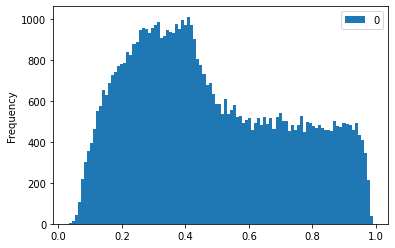

In [42]:
res.plot.hist(bins=100)

Does not look too bad...

In [43]:
print('Change shape and threshold to 0 1 for submission')
seq_predictions=np.transpose(res.to_numpy())[0]  # transformation to get (n,)
print(seq_predictions.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with 0.5 as thresold
seq_predictions = list(map(lambda x: 0 if x<0.5 else 1, seq_predictions))
seq_predictions = pd.DataFrame(seq_predictions)
seq_predictions

Change shape and threshold to 0 1 for submission
(59544,)


,0
0,1
1,0
2,0
3,0
4,1
...,...
59539,0
59540,0
59541,1
59542,1


In [44]:
seq_predictions.to_csv("outTry2.csv", index=False, header=False)

Done!